### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### Function Definition

In [3]:
def clean_data(data):
    # Drop columns with hints of subreddit
    data.drop(columns=['full_link', 'permalink', 'subreddit_id'], inplace = True)
    
    # Drop author_flaair_richtext
    data.dropna(subset=['author_flair_richtext'], inplace=True)
    
    # Drop features with less than 2 unique values
    temp = data.nunique().sort_values(ascending=True)
    temp[temp<=1]
    data.drop(columns=temp[temp<=1].index, inplace=True)
    
    # Check datatype of each features
    features_obj=[]
    features_bool=[]
    features_num=[]
    for col in data.columns:
        if data[col].dtypes == 'O':
            features_obj.append(col)
        elif data[col].dtypes == 'bool':
            features_bool.append(col)
        else:
            features_num.append(col)
    
    # Fill in all missing values for objects to be empty string
    for feature in features_obj:
        data[feature].fillna('', inplace=True)
    
    # Dropping rows with [deleted] or [removed] in selftext
    data.drop(index=data[data['selftext'].str.contains('\[removed\]|\[deleted\]')].index, inplace=True)
 
    return data  
    
    
def model_metrics(model, X_train, y_train, X_test, y_test):
    result = {}
    
    # Train Accuracy
    result['train_accuracy'] = [model.score(X_train, y_train)]
    print(f"Train Accuracy: {result['train_accuracy'][0]}")
    
    # Best TrainCV Accuracy
    result['trainCV_accuracy'] = [model.best_score_]
    print(f"TrainCV Accuracy: {result['trainCV_accuracy'][0]}")

    # Test Accuracy
    result['test_accuracy'] = [model.score(X_test, y_test)]
    print(f"Test Accuracy: {result['test_accuracy'][0]}")
    
    # Test data Predictions
    y_test_pred = model.predict(X_test)
    
    # Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    result['tn'] = [tn]
    result['fp'] = [fp]
    result['fn'] = [fn]
    result['tp'] = [tp]
    
    # Sensitivity
    sensitivity = tp/(tp+fn)
    result['sensitivity'] = [sensitivity]
    print(f"Sensitivity: {result['sensitivity'][0]}")
    
    # Specificity
    specificity = tn/(tn+fp)
    result['specificity'] = [specificity]
    print(f"Specificity: {result['specificity'][0]}")
    
    # Plot Confusion Matrix
    plot_confusion_matrix(model, X_test, y_test, display_labels=['LinusTechTips', 'TrashTaste'])

    # Best Parameters
    result['best_params'] = [model.best_params_]
    print(f"Best Parameters: {result['best_params'][0]}")
    
    # Best Estimator
    result['best_estimator'] = [model.best_estimator_]
    print(f"Best Estimator: {result['best_estimator'][0]}")
        
    return pd.DataFrame(result)


def top_bottom_predictors(model, X_train):
    # Getting the exponential of coefficients
    temp = pd.Series(dict(zip(X_train.columns, np.exp(lr.coef_[0]))))

    # Top 25 Predictors for TrashTaste
    plt.figure(figsize=(10,8))
    plt.title('Top 25 Predictors for Classifying Posts as TrashTaste', fontweight='bold', fontsize=15)
    sns.barplot(x=temp.sort_values(ascending=False).head(25), y=temp.sort_values(ascending=False).head(25).index)
    plt.xlabel('exponential^Coefficient', fontweight='bold', fontsize=12)
    plt.ylabel('Predictors', fontweight='bold', fontsize=12)

    # Bottom 25 Predictors for TrashTaste
    plt.figure(figsize=(10,8))
    plt.title('Bottom 25 Predictors for Classifying Posts as TrashTaste', fontweight='bold', fontsize=15)
    sns.barplot(x=temp.sort_values(ascending=True).head(25), y=temp.sort_values(ascending=True).head(25).index)
    plt.xlabel('exponential^Coefficient', fontweight='bold', fontsize=12)
    plt.ylabel('Predictors', fontweight='bold', fontsize=12)
    
    

def assess_model_metrics(model, X_train, y_train, X_test, y_test):
    # Train Score
    print(f"Train Accuracy: {model.score(X_train, y_train)}")

    # TrainCV Score
    print(f"TrainCV Accuracy: {cross_val_score(model, X_train, y_train, cv=5).mean()}")

    # Test Score
    print(f"Test Accuracy: {model.score(X_test, y_test)}")    

    # Predict y_test
    y_test_pred = model.predict(X_test)

    # Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

    # Sensitivity
    sensitivity = tp/(tp+fn)
    print(f"Sensitivity: {sensitivity}")

    # Specificity
    specificity = tn/(tn+fp)
    print(f"Specificity: {specificity}")

    # Plot Confusion Matrix
    plot_confusion_matrix(model, X_test, y_test, display_labels=['LinusTechTips', 'TrashTaste'])
    
    # Getting the exponential of coefficients
    temp = pd.Series(dict(zip(X_train.columns, np.exp(lr.coef_[0]))))

    # Top and bottom 25 Predictors for TrashTaste
    top_bottom_predictors(model, X_train)

### Load Data

In [3]:
linustech = pd.read_csv('../data/linustechtips.csv')
trashtaste = pd.read_csv('../data/trashtaste.csv')
data = pd.concat([linustech, trashtaste], ignore_index=True)
data.drop('Unnamed: 0', axis = 'columns', inplace=True)
data = clean_data(data)
data['subreddit'] = data['subreddit'].map({'LinusTechTips': 0, 'TrashTaste': 1})

In [4]:
# subreddit is the target, subreddit_id is the target
# Initial usable features are author, authur_fullname, 'full_link', 'domain', 'id', link_flair_richtext, link_flair_text, 
#'num_comments', 'permalink', 'selftext', 'title', 'url', whitelist_status', 'wls', 
# Dunno: 'created_utc'

### Prep Data

In [5]:
X = data['title']
y = data['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, stratify=y, random_state = 42)

### Deciding Which Vectorizer to Use for Random Forest

In order to determine which vectorizer would generate the best accuracy, 2 different models are ran and compared with each other accuracy, specificity and sensitivity.

#### TfidfVectorizer + Random Forest

In [6]:
# Instantiate Pipeline with TfidfVectorizer and Logisitic Regression

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())    
])

# Grid Search Parameters
pipe_tvec_params = {
    'tvec__stop_words': ['english'],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'tvec__max_features': [3000, 5000],
    'tvec__min_df': [1, 5],
    'rf__n_estimators': [200, 300],
    'rf__max_depth': [2, 5]
}

# Instantiate GridSearch and fit model using data
gs_tvec = GridSearchCV(pipe, param_grid=pipe_tvec_params, cv=5, verbose=1)
gs_tvec.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__max_depth': [2, 5],
                         'rf__n_estimators': [200, 300],
                         'tvec__max_features': [3000, 5000],
                         'tvec__min_df': [1, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tvec__stop_words': ['english']},
             verbose=1)

In [7]:
# Looking at the top 10 score to understand which are the common parameters
pd.DataFrame(gs_tvec.cv_results_).sort_values(by='rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__max_depth,param_rf__n_estimators,param_tvec__max_features,param_tvec__min_df,param_tvec__ngram_range,param_tvec__stop_words,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
42,0.575841,0.023435,0.058847,6.077473e-03,5,300,5000,1,"(1, 1)",english,"{'rf__max_depth': 5, 'rf__n_estimators': 300, ...",0.820513,0.833333,0.826645,0.818620,0.842697,0.828362,0.008828,1
43,0.602319,0.016306,0.063211,5.859840e-03,5,300,5000,1,"(1, 2)",english,"{'rf__max_depth': 5, 'rf__n_estimators': 300, ...",0.818910,0.834936,0.844302,0.812199,0.812199,0.824509,0.012922,2
36,0.585665,0.017365,0.049480,3.189675e-03,5,300,3000,1,"(1, 1)",english,"{'rf__max_depth': 5, 'rf__n_estimators': 300, ...",0.825321,0.831731,0.869984,0.794543,0.791332,0.822582,0.028639,3
44,0.619089,0.010705,0.061457,1.029885e-02,5,300,5000,1,"(1, 3)",english,"{'rf__max_depth': 5, 'rf__n_estimators': 300, ...",0.820513,0.838141,0.842697,0.812199,0.797753,0.822260,0.016582,4
37,0.596569,0.006427,0.064486,7.275415e-03,5,300,3000,1,"(1, 2)",english,"{'rf__max_depth': 5, 'rf__n_estimators': 300, ...",0.826923,0.796474,0.815409,0.817014,0.839486,0.819062,0.014189,5
26,0.445584,0.008763,0.046874,9.464947e-07,5,200,3000,1,"(1, 3)",english,"{'rf__max_depth': 5, 'rf__n_estimators': 200, ...",0.817308,0.807692,0.860353,0.794543,0.810594,0.818098,0.022386,6
30,0.397806,0.011522,0.036978,8.579677e-03,5,200,5000,1,"(1, 1)",english,"{'rf__max_depth': 5, 'rf__n_estimators': 200, ...",0.815705,0.812500,0.865169,0.805778,0.788122,0.817455,0.025694,7
24,0.388357,0.006196,0.038803,9.474668e-03,5,200,3000,1,"(1, 1)",english,"{'rf__max_depth': 5, 'rf__n_estimators': 200, ...",0.820513,0.778846,0.861958,0.812199,0.810594,0.816822,0.026658,8
19,0.564542,0.005743,0.057032,7.786959e-03,2,300,5000,1,"(1, 2)",english,"{'rf__max_depth': 2, 'rf__n_estimators': 300, ...",0.817308,0.806090,0.818620,0.821830,0.804173,0.813604,0.007098,9
25,0.419621,0.007105,0.048957,6.138334e-03,5,200,3000,1,"(1, 2)",english,"{'rf__max_depth': 5, 'rf__n_estimators': 200, ...",0.815705,0.814103,0.842697,0.791332,0.802568,0.813281,0.017137,10


Train Accuracy: 0.8549887712544113
TrainCV Accuracy: 0.828361526114335
Test Accuracy: 0.8142444658325313
Sensitivity: 0.9148936170212766
Specificity: 0.7145593869731801
Best Parameters: {'rf__max_depth': 5, 'rf__n_estimators': 300, 'tvec__max_features': 5000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}
Best Estimator: Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_features=5000, stop_words='english')),
                ('rf', RandomForestClassifier(max_depth=5, n_estimators=300))])


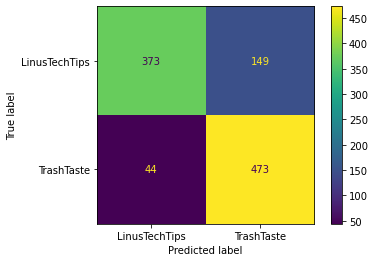

In [8]:
result = model_metrics(gs_tvec, X_train, y_train, X_test, y_test)

#### CountVectorizer + Random Forest

In [9]:
# Instantiate Pipeline with CountVectorizer and Logisitic Regression
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())    
])

# Grid Search Parameters
pipe_cvec_params = {
    'cvec__stop_words': ['english'],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'cvec__max_features': [3000, 5000],
    'cvec__min_df': [1, 5],
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [2, 5]
}

# Instantiate GridSearch and fit model using data
gs_cvec = GridSearchCV(pipe, param_grid=pipe_cvec_params, cv=5, verbose=1)
gs_cvec.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'cvec__max_features': [3000, 5000],
                         'cvec__min_df': [1, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__stop_words': ['english'],
                         'rf__max_depth': [2, 5],
                         'rf__n_estimators': [100, 200, 300]},
             verbose=1)

In [10]:
# Looking at the top 10 score to understand which are the common parameters
pd.DataFrame(gs_cvec.cv_results_).sort_values(by='rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,param_cvec__stop_words,param_rf__max_depth,param_rf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
53,0.614020,0.006231,0.063281,0.005741,5000,1,"(1, 3)",english,5,300,"{'cvec__max_features': 5000, 'cvec__min_df': 1...",0.842949,0.826923,0.853933,0.804173,0.813804,0.828356,0.018252,1
10,0.419700,0.011607,0.044529,0.006016,3000,1,"(1, 2)",english,5,200,"{'cvec__max_features': 3000, 'cvec__min_df': 1...",0.830128,0.818910,0.845907,0.810594,0.815409,0.824190,0.012623,2
41,0.556350,0.009432,0.058317,0.006374,5000,1,"(1, 1)",english,5,300,"{'cvec__max_features': 5000, 'cvec__min_df': 1...",0.825321,0.820513,0.852327,0.808989,0.812199,0.823870,0.015368,3
40,0.374616,0.009105,0.043228,0.007786,5000,1,"(1, 1)",english,5,200,"{'cvec__max_features': 5000, 'cvec__min_df': 1...",0.799679,0.838141,0.863563,0.800963,0.808989,0.822267,0.024891,4
4,0.382665,0.006487,0.037421,0.005867,3000,1,"(1, 1)",english,5,200,"{'cvec__max_features': 3000, 'cvec__min_df': 1...",0.839744,0.818910,0.857143,0.812199,0.783307,0.822260,0.025109,5
46,0.415902,0.008679,0.045133,0.005432,5000,1,"(1, 2)",english,5,200,"{'cvec__max_features': 5000, 'cvec__min_df': 1...",0.810897,0.806090,0.865169,0.818620,0.807384,0.821632,0.022201,6
5,0.551041,0.008124,0.053908,0.004982,3000,1,"(1, 1)",english,5,300,"{'cvec__max_features': 3000, 'cvec__min_df': 1...",0.826923,0.815705,0.833066,0.805778,0.826645,0.821624,0.009699,7
16,0.440630,0.009088,0.048654,0.009439,3000,1,"(1, 3)",english,5,200,"{'cvec__max_features': 3000, 'cvec__min_df': 1...",0.828526,0.831731,0.808989,0.802568,0.805778,0.815518,0.012143,8
47,0.586465,0.004979,0.057027,0.004468,5000,1,"(1, 2)",english,5,300,"{'cvec__max_features': 5000, 'cvec__min_df': 1...",0.834936,0.794872,0.831461,0.810594,0.802568,0.814886,0.015795,9
11,0.585604,0.009897,0.061979,0.004981,3000,1,"(1, 2)",english,5,300,"{'cvec__max_features': 3000, 'cvec__min_df': 1...",0.828526,0.806090,0.821830,0.813804,0.792937,0.812637,0.012404,10


Train Accuracy: 0.8402309913378249
TrainCV Accuracy: 0.828356381446269
Test Accuracy: 0.8026948989412896
Sensitivity: 0.941972920696325
Specificity: 0.6647509578544061
Best Parameters: {'cvec__max_features': 5000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': 'english', 'rf__max_depth': 5, 'rf__n_estimators': 300}
Best Estimator: Pipeline(steps=[('cvec',
                 CountVectorizer(max_features=5000, ngram_range=(1, 3),
                                 stop_words='english')),
                ('rf', RandomForestClassifier(max_depth=5, n_estimators=300))])


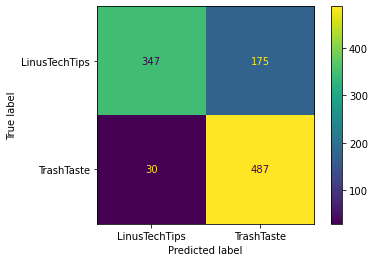

In [11]:
result = pd.concat([result, model_metrics(gs_cvec, X_train, y_train, X_test, y_test)])

In [24]:
# Results of the 2 models
result

,train_accuracy,trainCV_accuracy,test_accuracy,tn,fp,fn,tp,sensitivity,specificity,best_params,best_estimator
0,0.877125,0.835738,0.829644,390,132,45,472,0.912959,0.747126,"{'rf__max_depth': 5, 'rf__n_estimators': 300, ...","(TfidfVectorizer(max_features=5000, stop_words..."
0,0.862368,0.830282,0.833494,390,132,41,476,0.920696,0.747126,"{'cvec__max_features': 5000, 'cvec__min_df': 1...","(CountVectorizer(max_features=5000, ngram_rang..."


### Results
Since there is no significant differences between TF-IDF and count vectorizer, TF-IDF is chosen so that we can see how different estimators affect the accuracy.

|Estimator|Vectorizers|Train Accuracy|TrainCV Accuracy|Test Accuracy|Sensitivity|Specificity|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|Random Forest|Tfidf Vectorizer|0.877125|0.835738|0.829644|0.912959|0.747126|
|Random Forest|Count Vectorizer|0.862368|0.830282|0.833494|0.920696|0.747126|

### Does having more predictors help?
Trying to improve the accuracy by using more predictors:-
- selftext
- link_flair_text
- author_fullname
- whitelist_status

In [13]:
# Train-Test Split X and y dataset
X = data[['title', 'author_fullname', 'selftext', 'whitelist_status', 'link_flair_text']]
y = data['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, stratify=y, random_state = 42)

#### Adding selftext as predictor
Adding selftext caused the accuracy to decrease by 1% and sensitivity to increase by 5% while decreasing specificity by 6% as comapared to just using title terms for modeling.

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Train Accuracy: 0.835097850497273
TrainCV Accuracy: 0.8245107420669218
Test Accuracy: 0.8267564966313763
Sensitivity: 0.9729206963249516
Specificity: 0.6819923371647509
Best Parameters: {'rf__max_depth': 5, 'rf__n_estimators': 200, 'tvec__max_features': 5000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}
Best Estimator: Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('rf', RandomForestClassifier(max_depth=5, n_estimators=200))])


,train_accuracy,trainCV_accuracy,test_accuracy,tn,fp,fn,tp,sensitivity,specificity,best_params,best_estimator
0,0.835098,0.824511,0.826756,356,166,14,503,0.972921,0.681992,"{'rf__max_depth': 5, 'rf__n_estimators': 200, ...","(TfidfVectorizer(max_features=5000, ngram_rang..."


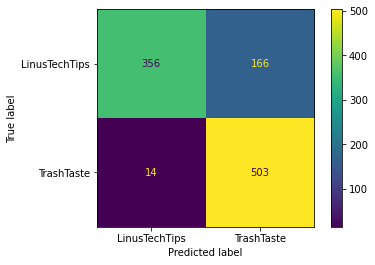

In [14]:
# Placing all text features into a column vector
X_train_text = X_train['title'] + " " + X_train['selftext']
X_test_text = X_test['title'] + " " + X_test['selftext']

# Finding the best hyperparameters for text feature first
# Instantiate Pipeline with TfidfVectorizer and Logisitic Regression
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())     
])

# Grid Search Parameters
pipe_tvec_params = {
    'tvec__stop_words': ['english'],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'tvec__max_features': [3000, 5000, 10000],
    'tvec__min_df': [1, 5],
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [2, 5]
}

# Instantiate GridSearch and fit model using data
gs_tvec = GridSearchCV(pipe, param_grid=pipe_tvec_params, cv=5, verbose=1)
gs_tvec.fit(X_train_text, y_train)

# Assessing model metrics
model_metrics(gs_tvec, X_train_text, y_train, X_test_text, y_test)

#### Adding link_flair_text as predictor
Adding link_flair_text greatly improved the accuracy by ~13% to 95.5% while improving the sensitivity and specificity to 96.9% and 94.0% respectively.

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Train Accuracy: 0.9541225537375682
TrainCV Accuracy: 0.9550834465160308
Test Accuracy: 0.9547641963426372
Sensitivity: 0.9690522243713733
Specificity: 0.9406130268199234
Best Parameters: {'rf__max_depth': 5, 'rf__n_estimators': 200, 'tvec__max_features': 10000, 'tvec__min_df': 5, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}
Best Estimator: Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_features=10000, min_df=5,
                                 ngram_range=(1, 2), stop_words='english')),
                ('rf', RandomForestClassifier(max_depth=5, n_estimators=200))])


,train_accuracy,trainCV_accuracy,test_accuracy,tn,fp,fn,tp,sensitivity,specificity,best_params,best_estimator
0,0.954123,0.955083,0.954764,491,31,16,501,0.969052,0.940613,"{'rf__max_depth': 5, 'rf__n_estimators': 200, ...","(TfidfVectorizer(max_features=10000, min_df=5,..."


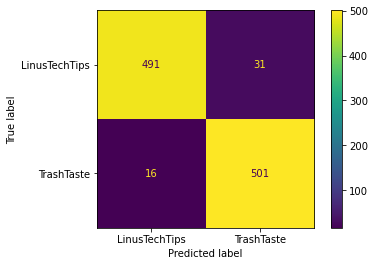

In [15]:
# Placing all text features into a column vector
X_train_text = X_train['title'] + " " + X_train['selftext'] + " " + X_train['link_flair_text']
X_test_text = X_test['title'] + " " + X_test['selftext'] + " " + X_test['link_flair_text']

# Finding the best hyperparameters for text feature first
# Instantiate Pipeline with TfidfVectorizer and Logisitic Regression
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())     
])

# Grid Search Parameters
pipe_tvec_params = {
    'tvec__stop_words': ['english'],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'tvec__max_features': [3000, 5000, 10000],
    'tvec__min_df': [1, 5],
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [2, 5]
}

# Instantiate GridSearch and fit model using data
gs_tvec = GridSearchCV(pipe, param_grid=pipe_tvec_params, cv=5, verbose=1)
gs_tvec.fit(X_train_text, y_train)

# Assessing model metrics
model_metrics(gs_tvec, X_train_text, y_train, X_test_text, y_test)

#### Add 'author_fullname' as predictor
Adding author_fullname caused the accuracy, sensitivity and specificity to drop by 1% from previous model.

In [16]:
# Vectorizing X_train and X_test
tvec = TfidfVectorizer(stop_words=gs_tvec.best_params_['tvec__stop_words'], 
                       ngram_range=gs_tvec.best_params_['tvec__ngram_range'],
                       max_features=gs_tvec.best_params_['tvec__max_features'],
                       min_df=gs_tvec.best_params_['tvec__min_df'])
tvec.fit(X_train_text)
X_train_vec = tvec.transform(X_train_text)
X_test_vec = tvec.transform(X_test_text)

# Convert into DataFrame
X_train_vec_df = pd.DataFrame(X_train_vec.toarray(), columns = tvec.get_feature_names())
X_test_vec_df = pd.DataFrame(X_test_vec.toarray(), columns = tvec.get_feature_names())


# Merge OHE dataframe with vectorized dataframe for train and test X
X_train_vec_df = pd.merge(left=X_train_vec_df,
                         right=pd.get_dummies(X_train[['author_fullname']], drop_first=True).reset_index(drop=True),
                         left_index=True,
                         right_index=True)

X_test_vec_df = pd.merge(left=X_test_vec_df,
                         right=pd.get_dummies(X_test[['author_fullname']], drop_first=False).reset_index(drop=True),
                         left_index=True,
                         right_index=True)

# Preparing Test Data due to one hot encoding
# To compare and check for missing and extra columns
missing_col=[]
extra_col=[]

# Get the missing columns
for col in X_train_vec_df.columns:
    if col not in X_test_vec_df.columns:
        missing_col.append(col)

# Get the extra columns
for col in X_test_vec_df.columns:
    if col not in X_train_vec_df.columns:
        extra_col.append(col)
        
        
# To compare and check for missing and extra columns
missing_col=[]
extra_col=[]

# Get the missing columns
for col in X_train_vec_df.columns:
    if col not in X_test_vec_df.columns:
        missing_col.append(col)

# Get the extra columns
for col in X_test_vec_df.columns:
    if col not in X_train_vec_df.columns:
        extra_col.append(col)
        
# Add missing columns and set to 0
for col in missing_col:
    X_test_vec_df[col] = 0

# Drop the extra columns
X_test_vec_df.drop(columns=extra_col)

# Reorder the columns of the test dataframe to match the train dataframe
X_test_vec_df = X_test_vec_df[X_train_vec_df.columns]

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Train Accuracy: 0.9518768046198267
TrainCV Accuracy: 0.943528522039758
Test Accuracy: 0.9432146294513956
Sensitivity: 0.9516441005802708
Specificity: 0.9348659003831418
Best Parameters: {'max_depth': 5, 'n_estimators': 300}
Best Estimator: RandomForestClassifier(max_depth=5, n_estimators=300)


,train_accuracy,trainCV_accuracy,test_accuracy,tn,fp,fn,tp,sensitivity,specificity,best_params,best_estimator
0,0.951877,0.943529,0.943215,488,34,25,492,0.951644,0.934866,"{'max_depth': 5, 'n_estimators': 300}","(DecisionTreeClassifier(max_depth=5, max_featu..."


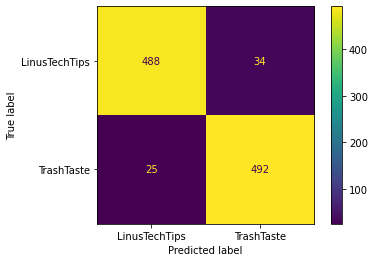

In [17]:
# Instantiate Random Forest Classifier
rf = RandomForestClassifier()

# Define rf parameters to gridsearch
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 5]
}

# Instantiate gridsearch
gs = GridSearchCV(rf, param_grid=rf_params, cv=5, verbose=1)

# Fit gridsearch
gs.fit(X_train_vec_df, y_train)

# Assessing model metrics
model_metrics(gs, X_train_vec_df, y_train, X_test_vec_df, y_test)

#### Adding 'whitelist_status' instead of 'author_fullname'
Adding 'whitelist_status' instead of 'author_fullname' improved the accuracy, sensitivity and specificity to more than 99%.

In [18]:
# Vectorizing X_train and X_test
tvec = TfidfVectorizer(stop_words=gs_tvec.best_params_['tvec__stop_words'], 
                       ngram_range=gs_tvec.best_params_['tvec__ngram_range'],
                       max_features=gs_tvec.best_params_['tvec__max_features'],
                       min_df=gs_tvec.best_params_['tvec__min_df'])
tvec.fit(X_train_text)
X_train_vec = tvec.transform(X_train_text)
X_test_vec = tvec.transform(X_test_text)

# Convert into DataFrame
X_train_vec_df = pd.DataFrame(X_train_vec.toarray(), columns = tvec.get_feature_names())
X_test_vec_df = pd.DataFrame(X_test_vec.toarray(), columns = tvec.get_feature_names())


# Merge OHE dataframe with vectorized dataframe for train and test X
X_train_vec_df = pd.merge(left=X_train_vec_df,
                         right=pd.get_dummies(X_train[['whitelist_status']], drop_first=True).reset_index(drop=True),
                         left_index=True,
                         right_index=True)

X_test_vec_df = pd.merge(left=X_test_vec_df,
                         right=pd.get_dummies(X_test[['whitelist_status']], drop_first=False).reset_index(drop=True),
                         left_index=True,
                         right_index=True)

# Preparing Test Data due to one hot encoding
# To compare and check for missing and extra columns
missing_col=[]
extra_col=[]

# Get the missing columns
for col in X_train_vec_df.columns:
    if col not in X_test_vec_df.columns:
        missing_col.append(col)

# Get the extra columns
for col in X_test_vec_df.columns:
    if col not in X_train_vec_df.columns:
        extra_col.append(col)
        
        
# To compare and check for missing and extra columns
missing_col=[]
extra_col=[]

# Get the missing columns
for col in X_train_vec_df.columns:
    if col not in X_test_vec_df.columns:
        missing_col.append(col)

# Get the extra columns
for col in X_test_vec_df.columns:
    if col not in X_train_vec_df.columns:
        extra_col.append(col)
        
# Add missing columns and set to 0
for col in missing_col:
    X_test_vec_df[col] = 0

# Drop the extra columns
X_test_vec_df.drop(columns=extra_col)

# Reorder the columns of the test dataframe to match the train dataframe
X_test_vec_df = X_test_vec_df[X_train_vec_df.columns]

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Train Accuracy: 0.9974334295797241
TrainCV Accuracy: 0.9961492159525868
Test Accuracy: 0.9990375360923965
Sensitivity: 1.0
Specificity: 0.9980842911877394
Best Parameters: {'max_depth': 5, 'n_estimators': 300}
Best Estimator: RandomForestClassifier(max_depth=5, n_estimators=300)


,train_accuracy,trainCV_accuracy,test_accuracy,tn,fp,fn,tp,sensitivity,specificity,best_params,best_estimator
0,0.997433,0.996149,0.999038,521,1,0,517,1.0,0.998084,"{'max_depth': 5, 'n_estimators': 300}","(DecisionTreeClassifier(max_depth=5, max_featu..."


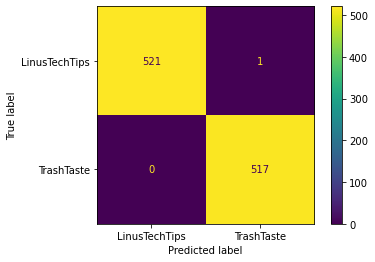

In [19]:
# Instantiate Random Forest Classifier
rf = RandomForestClassifier()

# Define rf parameters to gridsearch
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 5]
}

# Instantiate gridsearch
gs = GridSearchCV(rf, param_grid=rf_params, cv=5, verbose=1)

# Fit gridsearch
gs.fit(X_train_vec_df, y_train)

# Assessing model metrics
model_metrics(gs, X_train_vec_df, y_train, X_test_vec_df, y_test)

#### Adding both 'whitelist_status' and 'author_fullname' as predictors
Adding both 'whitelist_status' and 'author_fullname' caused the accuracy, sensitivity and specificity to drop about ~1% to ~2%.

In [22]:
# Vectorizing X_train and X_test
tvec = TfidfVectorizer(stop_words=gs_tvec.best_params_['tvec__stop_words'], 
                       ngram_range=gs_tvec.best_params_['tvec__ngram_range'],
                       max_features=gs_tvec.best_params_['tvec__max_features'],
                       min_df=gs_tvec.best_params_['tvec__min_df'])
tvec.fit(X_train_text)
X_train_vec = tvec.transform(X_train_text)
X_test_vec = tvec.transform(X_test_text)

# Convert into DataFrame
X_train_vec_df = pd.DataFrame(X_train_vec.toarray(), columns = tvec.get_feature_names())
X_test_vec_df = pd.DataFrame(X_test_vec.toarray(), columns = tvec.get_feature_names())


# Merge OHE dataframe with vectorized dataframe for train and test X
X_train_vec_df = pd.merge(left=X_train_vec_df,
                         right=pd.get_dummies(X_train[['whitelist_status',  'author_fullname']], drop_first=True).reset_index(drop=True),
                         left_index=True,
                         right_index=True)

X_test_vec_df = pd.merge(left=X_test_vec_df,
                         right=pd.get_dummies(X_test[['whitelist_status',  'author_fullname']], drop_first=False).reset_index(drop=True),
                         left_index=True,
                         right_index=True)

# Preparing Test Data due to one hot encoding
# To compare and check for missing and extra columns
missing_col=[]
extra_col=[]

# Get the missing columns
for col in X_train_vec_df.columns:
    if col not in X_test_vec_df.columns:
        missing_col.append(col)

# Get the extra columns
for col in X_test_vec_df.columns:
    if col not in X_train_vec_df.columns:
        extra_col.append(col)
        
        
# To compare and check for missing and extra columns
missing_col=[]
extra_col=[]

# Get the missing columns
for col in X_train_vec_df.columns:
    if col not in X_test_vec_df.columns:
        missing_col.append(col)

# Get the extra columns
for col in X_test_vec_df.columns:
    if col not in X_train_vec_df.columns:
        extra_col.append(col)
        
# Add missing columns and set to 0
for col in missing_col:
    X_test_vec_df[col] = 0

# Drop the extra columns
X_test_vec_df.drop(columns=extra_col)

# Reorder the columns of the test dataframe to match the train dataframe
X_test_vec_df = X_test_vec_df[X_train_vec_df.columns]

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Train Accuracy: 0.9932627526467758
TrainCV Accuracy: 0.99422459562909
Test Accuracy: 0.9855630413859481
Sensitivity: 0.9787234042553191
Specificity: 0.9923371647509579
Best Parameters: {'max_depth': 5, 'n_estimators': 200}
Best Estimator: RandomForestClassifier(max_depth=5, n_estimators=200)


,train_accuracy,trainCV_accuracy,test_accuracy,tn,fp,fn,tp,sensitivity,specificity,best_params,best_estimator
0,0.993263,0.994225,0.985563,518,4,11,506,0.978723,0.992337,"{'max_depth': 5, 'n_estimators': 200}","(DecisionTreeClassifier(max_depth=5, max_featu..."


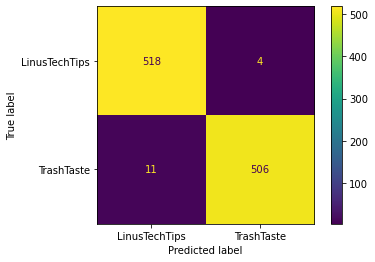

In [23]:
# Instantiate Random Forest Classifier
rf = RandomForestClassifier()

# Define rf parameters to gridsearch
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 5]
}

# Instantiate gridsearch
gs = GridSearchCV(rf, param_grid=rf_params, cv=5, verbose=1)

# Fit gridsearch
gs.fit(X_train_vec_df, y_train)

# Assessing model metrics
model_metrics(gs, X_train_vec_df, y_train, X_test_vec_df, y_test)

### Final Production Model
Despite slightly less accurate, the final production model is decided to be TF-IDF with random forest using predictors such as 'title', 'selftext', 'link_flair_text', author_fullname' and 'whitelist_status'. While excluding 'author_fullname' would increase the accuracy slightly, it was included in the final model to make the model more generalizable as other subreddits might not have very distinctively different 'whitelist_status'.

<img src="..\imgs\Final Production Model - Random Forest.PNG">

### Validation on Old Dataset
To validate if the model would still work on dataset from 2021 or earlier, dataset from late 2020 was used and determine the accuracy of the model. The result of the classification is 98%.

In [4]:
linustech_old = pd.read_csv('../data/linustechtips_2020.csv')
trashtaste_old = pd.read_csv('../data/trashtaste_2020.csv')
data_old = pd.concat([linustech_old, trashtaste_old], ignore_index=True)
data_old = clean_data(data_old)
data_old['subreddit'] = data_old['subreddit'].map({'LinusTechTips': 0, 'TrashTaste': 1})

In [25]:
# Train-Test Split X and y dataset
X_val = data_old[['title', 'author_fullname', 'selftext', 'whitelist_status', 'link_flair_text']]
y_val = data_old['subreddit']

# Placing all text features into a column vector
X_val_text = X_val['title'] + " " + X_val['selftext'] + " " + X_val['link_flair_text']

# Vectorizing X_val_text
X_val_text_vec = tvec.transform(X_val_text)

# Convert into DataFrame
X_val_text_vec_df = pd.DataFrame(X_val_text_vec.toarray(), columns = tvec.get_feature_names())

# Merge OHE dataframe with vectorized dataframe for train and test X
X_val_text_vec_df = pd.merge(left=X_val_text_vec_df,
                         right=pd.get_dummies(X_val[['whitelist_status', 'author_fullname']], drop_first=False).reset_index(drop=True),
                         left_index=True,
                         right_index=True)

# Preparing Data due to one hot encoding
# To compare and check for missing and extra columns
missing_col=[]
extra_col=[]

# Get the missing columns
for col in X_train_vec_df.columns:
    if col not in X_val_text_vec_df.columns:
        missing_col.append(col)

# Get the extra columns
for col in X_val_text_vec_df.columns:
    if col not in X_train_vec_df.columns:
        extra_col.append(col)
        
# Add missing columns and set to 0
for col in missing_col:
    X_val_text_vec_df[col] = 0

# Drop the extra columns
X_val_text_vec_df.drop(columns=extra_col)

# Reorder the columns of the test dataframe to match the train dataframe
X_val_text_vec_df = X_val_text_vec_df[X_train_vec_df.columns]

Accuracy: 0.9826619071902091
Sensitivity: 0.9773515609059376
Specificity: 0.9879690048939641


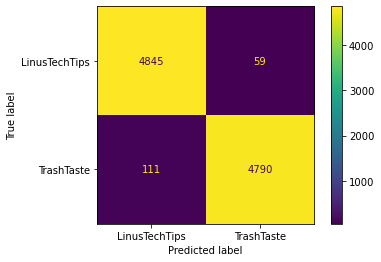

In [27]:
# Train Score
print(f'Accuracy: {gs.score(X_val_text_vec_df, y_val)}')

# Predict y_test
y_text_pred = gs.predict(X_val_text_vec_df)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_val, y_text_pred).ravel()

# Sensitivity
sensitivity = tp/(tp+fn)
print(f"Sensitivity: {sensitivity}")

# Specificity
specificity = tn/(tn+fp)
print(f"Specificity: {specificity}")

# Plot Confusion Matrix
plot_confusion_matrix(gs, X_val_text_vec_df, y_val, display_labels=['LinusTechTips', 'TrashTaste'])

### Conclusion

It is possible to use data from the subreddit posts to infer which subreddit they came from with high accuracy. While both models are usable in predicting which subreddit the posts came from, the 1st model (parametric model) is still preferred as compared to the 2nd model (random forest) due to its slightly higher accuracy. When using the 2 models to classify posts from late 2020, the accuracy is 99% for the 1st model and 98% for the 2nd model.

||Logistic Regression|Random Forest|
|:---:|:---:|:---:|
||<img src='..\imgs\Tfidf_logisitic_confusion_matrix_validation.PNG'>|<img src='..\imgs\Tfidf_rf_confusion_matrix_validation.PNG'>|
|Accuracy|0.990209|0.982661|
|Sensitivity|0.986329|0.977351|
|Specificity|0.994086|0.987969|

### Potential Improvements
As the reason this current production model is showing very high accuracy is due to the significant difference between the whitelist_status of the 2 subreddit chosen, when training model for other subreddits, we could:-
- Include comments from each subreddit post
- author_flair_richtext if the usage rate is high for other subreddits
- Increasing the amount of dataset used for training
- Checking if there are images in the post
    - Certain subreddits tend to have more image in post

### Business Recommendations
- Reddit could show a list of subreddits to the users which the posts would be suitable to be posted in
- With the logisitic regression model, since there are coefficients that indicate what are the key terms for the subreddits, Reddit could list down the current trend or hot words in the subreddit